In [1]:
import numpy as np

import nibabel as nib

import skimage

import matplotlib.pyplot as plt
from seaborn import kdeplot

import os
import os.path as op
import sys

from tqdm.notebook import tqdm

sys.path.append('..')
sys.path.append('../interpolation')

from interpolation import interpolation as interp

In [10]:
figure_loc = op.join('..', 'figures-MNI')
figure_loc = ("/Users/acionca/Library/CloudStorage/GoogleDrive-cionkito@gmail.com/My Drive/_Work/CHUV/"+
              "OHB2024-Poster/figures-MNI")
os.makedirs(figure_loc, exist_ok=True)

# Histogram matching

In [3]:
path_to_data = "/Users/acionca/data"
derivative_name = "ants-t1N4bfcorr-ss"

#path_to_data = "/home/acionca/Documents/data"
#derivative_name = "ants-t1N4bfcorr-b80-noSkull"

path_to_imgs = op.join(path_to_data,"hcph-template/multivar-v00/derivatives"
                f"/{derivative_name}")

anat_files_list = interp.get_anat_filenames(path_to_imgs, pattern="corrden",
                                            exclude=["in0048", "rerun"])

mask_files_list = interp.get_anat_filenames(path_to_imgs, pattern="brainmask",
                                            exclude=["in0048", "rerun"])

path_to_mni = op.join(path_to_data, "hcph-template/mni_template/mni_template-res0.8mm.nii.gz")
ref_img = nib.load(path_to_mni)
ref_data = ref_img.get_fdata()

vmax = 255
scaled_ref_data = ref_data * vmax

path_to_normalized = op.join(path_to_data, "hcph-template/multivar-v00/derivatives"
                      f"/{derivative_name}")

norm_files_list = interp.get_anat_filenames(path_to_normalized, exclude=["in0048", "rerun"])

first_img = nib.load(anat_files_list[0])
#first_img = nib.load(norm_files_list[0])
first_data = first_img.get_fdata()
first_mask = nib.load(mask_files_list[0]).get_fdata()
first_data_masked = first_data * first_mask

In [4]:
anat_files_list_red = anat_files_list[:5]
mask_files_list_red = mask_files_list[:5]

first_img = nib.load(anat_files_list_red[0])
first_data = first_img.get_fdata()

masked = []
matched = []
img_list = []
for i, file in enumerate(tqdm(anat_files_list_red)):
    image = nib.load(file)
    mask = nib.load(mask_files_list_red[i]).get_fdata()

    masked_data = mask * image.get_fdata()
    masked.append(masked_data)
    matched_data = skimage.exposure.match_histograms(masked_data, first_data_masked)

    matched_array = np.zeros_like(masked_data)
    matched_array[mask > 0] = matched_data[mask > 0]

    matched.append(matched_array)

    matched_img = nib.Nifti1Image(matched_array, affine=image.affine, dtype="uint8")
    img_list.append(matched_img)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

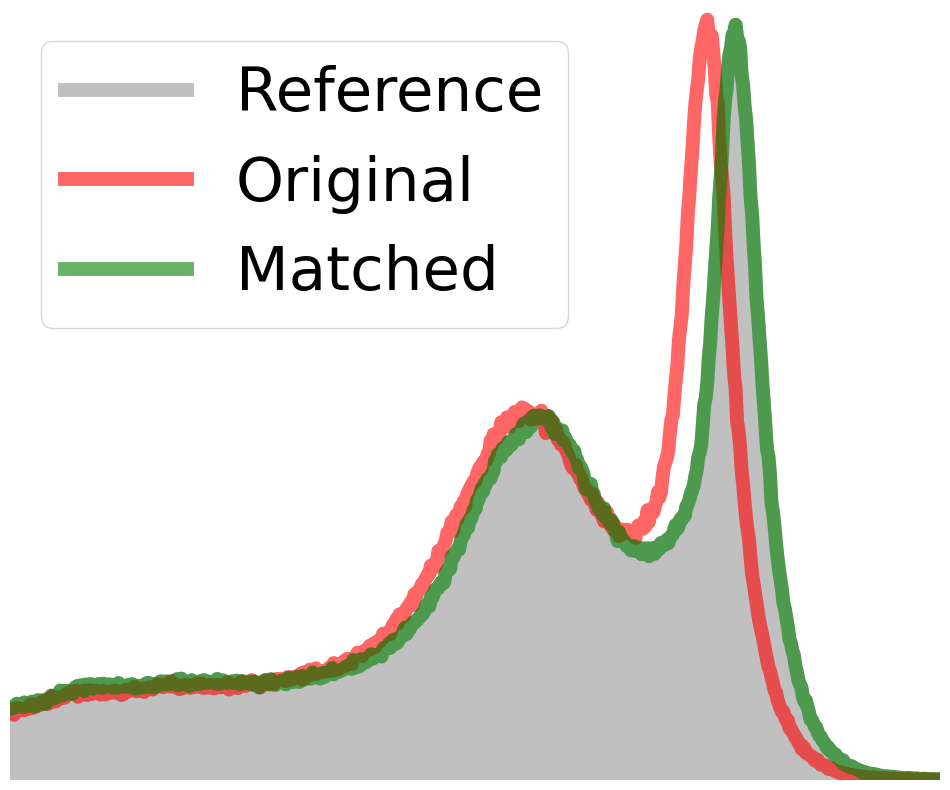

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
#fig, axes = plt.subplots(nrows=len(anat_files_list_red), ncols=1, figsize=(10, 5*len(anat_files_list_red)))

percentile_to_show = 99
img_percentile = np.percentile(first_data.flatten(), percentile_to_show, method="nearest")+20
nbins=(first_data.max()/2).astype(int)

img_id = 2

# Plot reference image
hist_values, hist_bins = np.histogram(first_data_masked.flatten(), bins=nbins, range=(10, img_percentile))
axes.plot(hist_bins[:-1], hist_values, lw=10, color="silver", label="Reference")
axes.fill_betweenx(hist_values, hist_bins[:-1], color="silver")

# Plot original image
hist_values, hist_bins = np.histogram(masked[img_id].flatten(), bins=nbins, range=(10, img_percentile))
axes.plot(hist_bins[:-1], hist_values, lw=10, alpha=.6, color="red", label="Original")

# Plot matched image
hist_values, hist_bins = np.histogram(matched[img_id].flatten(), bins=nbins, range=(10, img_percentile))
axes.plot(hist_bins[:-1], hist_values, lw=10, alpha=.6, color="green", label="Matched")


axes.spines[:].set_visible(False)
axes.spines[:].set_linewidth(2)

axes.set_xticks([])
axes.set_yticks([])
axes.axis([100, 700, 0, 20000])
axes.legend(fontsize=44)
#fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

fig.savefig(op.join(figure_loc, "histogram_matching.png"), dpi=300, bbox_inches="tight")

## Some more definitions

In [6]:
path_to_images = "/Users/acionca/data/hcph-template"

original_img = nib.load(op.join(path_to_images, "multivar-v00/sub-001_ses-001_T1w.nii.gz"))
skullstrip = nib.load(op.join(path_to_images, "multivar-v00/derivatives/ants-t1N4bfcorr-ss/sub-001_ses-001_desc-noSkull_T1w.nii.gz"))
brainmask = nib.load(op.join(path_to_images, "multivar-v00/derivatives/ants-t1N4bfcorr-ss/sub-001_ses-001_desc-brainmask_T1w.nii.gz"))
n4corrden = nib.load(op.join(path_to_images, "multivar-v00/derivatives/allInRef-noskull/sub-001_ses-001_space-inRef_desc-N4corrdenhist_T1w.nii.gz"))
aligned_T2w = nib.load(op.join(path_to_images, "multivar-v00/derivatives/allInRef-noskull/sub-001_ses-001_space-inRef_desc-N4corrdenhist_T2w.nii.gz"))

In [7]:
mask_data = brainmask.get_fdata()

from scipy.ndimage import binary_dilation, binary_erosion, binary_closing

z_coords = 115
max_int = 1000

all_imgs = [original_img, skullstrip, n4corrden, aligned_T2w]

my_gray = plt.get_cmap("gray")

n_alpha = 1
my_gray._init()
alpha_vect = [0] * n_alpha + [1] * (my_gray.N + 3 - n_alpha)

print(my_gray._lut.shape)
my_gray._lut[:, -1] = alpha_vect

(259, 4)


# Initial images

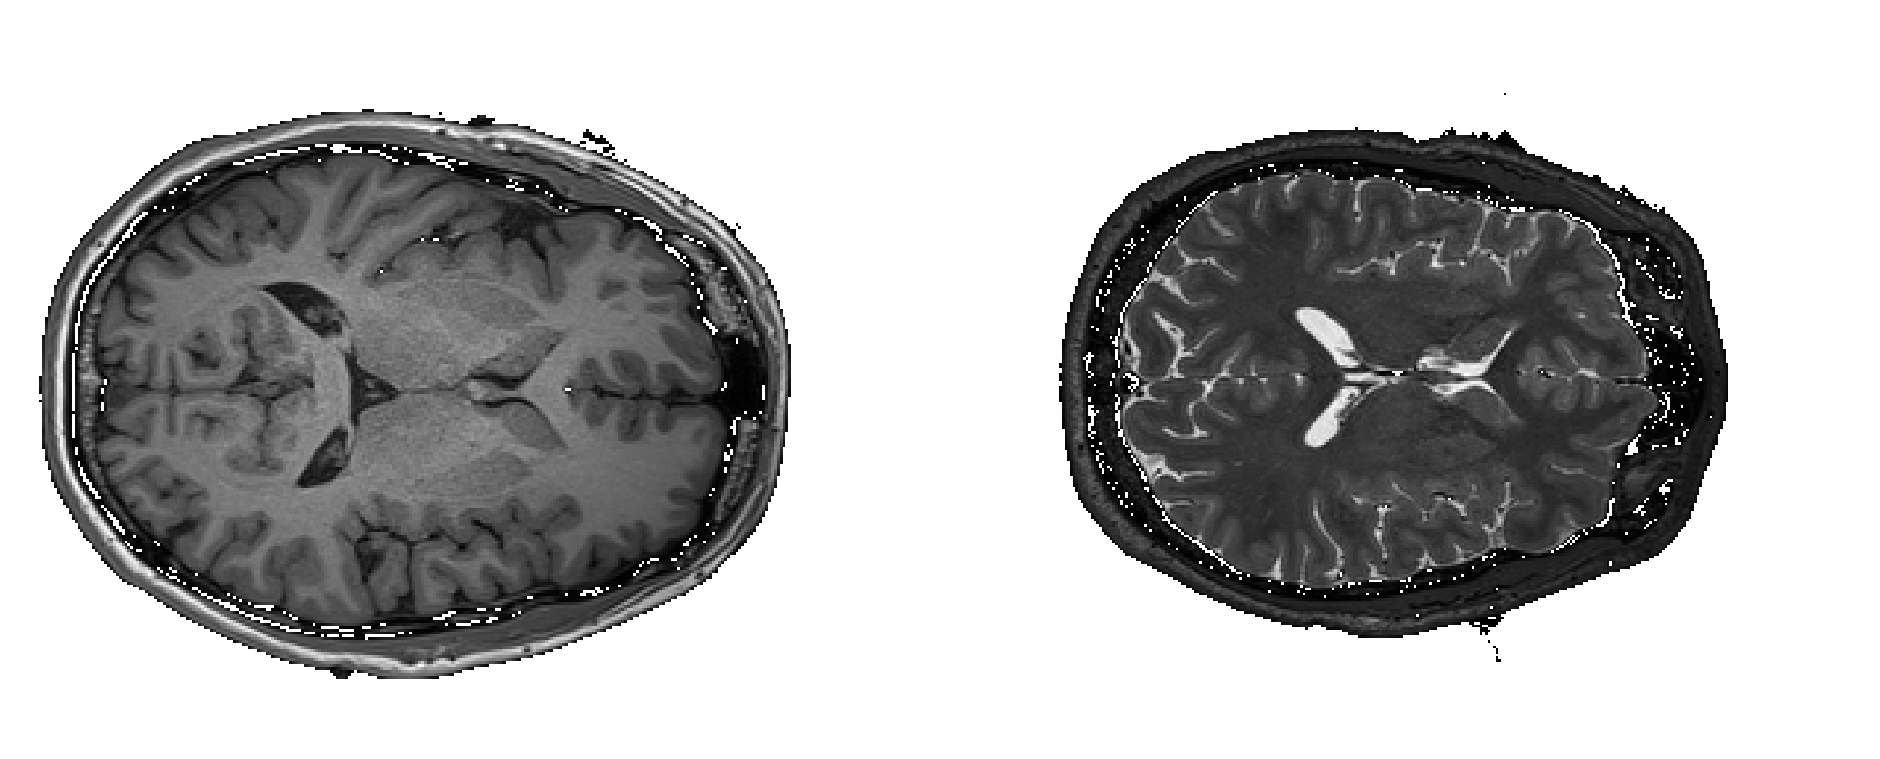

In [8]:
original_images = [nib.load(op.join(path_to_images, f"multivar-v00/sub-001_ses-001_T{i}w.nii.gz")) for i in [1, 2]]

fig, axes = plt.subplots(nrows=1, ncols=len(original_images), figsize=(12*len(original_images), 10))

for ax in axes:
    ax.axis("off")

threshs = [20, 10]
z_coords_list = [90, 205]

for i, (ax, image) in enumerate(zip(axes, original_images)):
    data = image.get_fdata()[:, :, z_coords_list[i]]

    mask_from_data = (data > threshs[i])
    #mask_from_data = binary_dilation(mask_from_data, iterations=7)
    mask_from_data = binary_closing(mask_from_data, iterations=10)
    
    #data[mask_data[:, :, z_coords] == 0] = max_int
    ax.imshow(np.abs(data)*mask_from_data, interpolation="none", cmap=my_gray, vmin=0)#, vmax=max_int)

fig.savefig(op.join(figure_loc, "original_imgs.png"), dpi=300, bbox_inches="tight", transparent=True)

# Brain plots

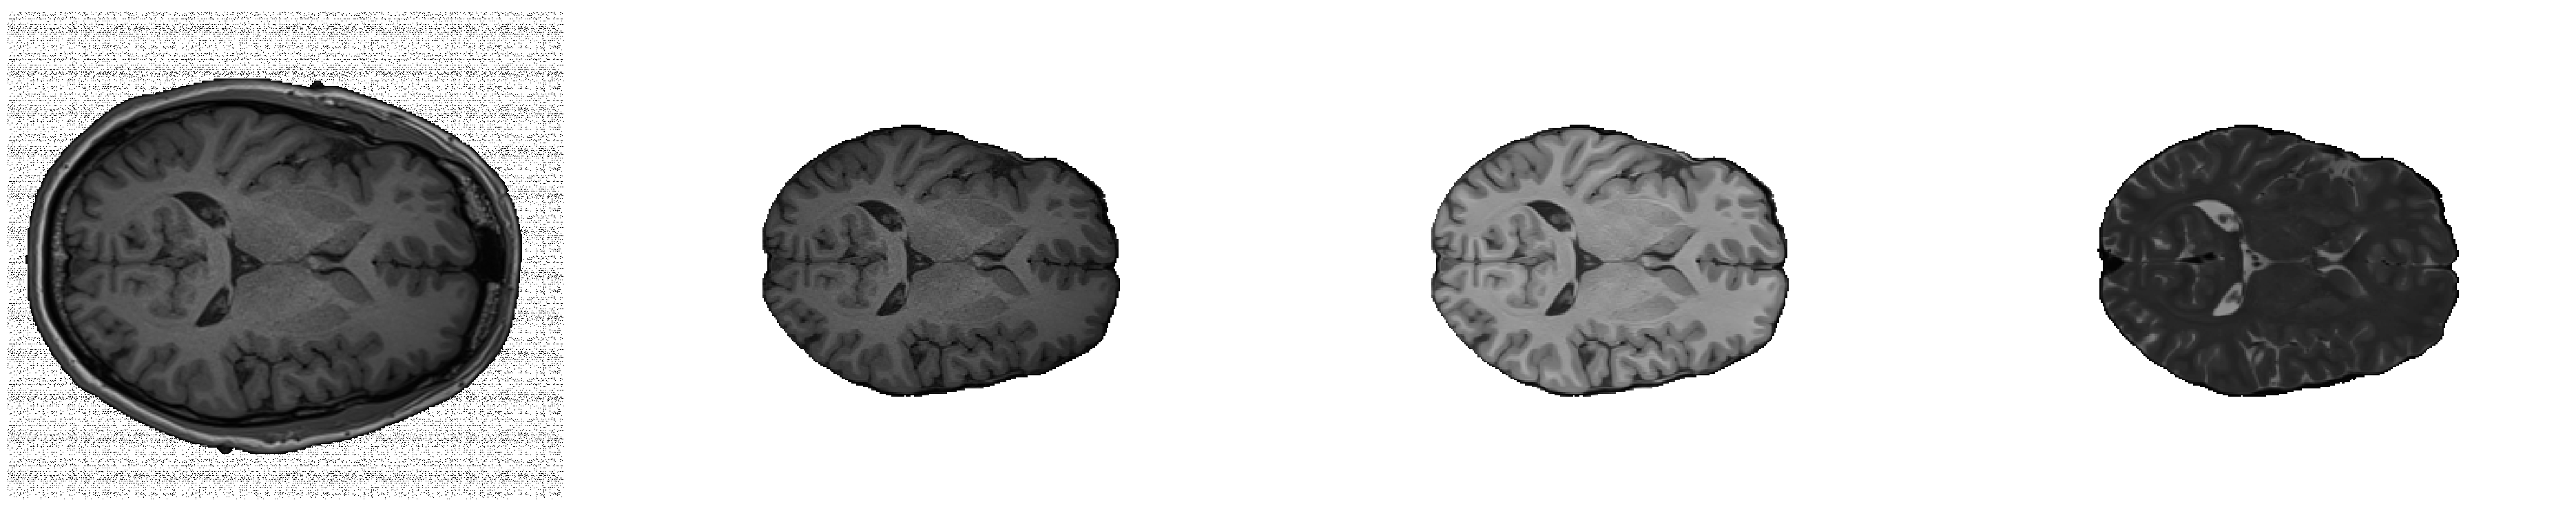

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=len(all_imgs), figsize=(12*len(all_imgs), 10))

for ax in axes:
    ax.axis("off")

original_dilate = original_img.get_fdata()[:, :, 90]

mask_from_data = (original_dilate > 40)
#mask_from_data = binary_dilation(mask_from_data, iterations=7)
mask_from_data = binary_closing(mask_from_data, iterations=9)
original_dilate += 10*mask_from_data

axes[0].imshow(original_dilate*mask_from_data, cmap=my_gray, vmin=0, vmax=max_int)

for ax, image in zip(axes[1:], all_imgs[1:]):
    data = image.get_fdata()[:, :, z_coords]
    #data[mask_data[:, :, z_coords] == 0] = max_int
    ax.imshow(np.abs(data)+10*mask_data[:, :, z_coords], interpolation="none", cmap=my_gray, vmin=0, vmax=max_int)

fig.savefig(op.join(figure_loc, "all_brains.png"), dpi=300, bbox_inches="tight", transparent=True)

# Mosaic plots

In [10]:
path_to_movie = op.join(path_to_images, "concat_img_noskull_N37.nii.gz")

n_frames = 5

movie_data = nib.load(path_to_movie).slicer[..., :n_frames].get_fdata()[:, :, z_coords]
movie_data.shape

(302, 338, 5)

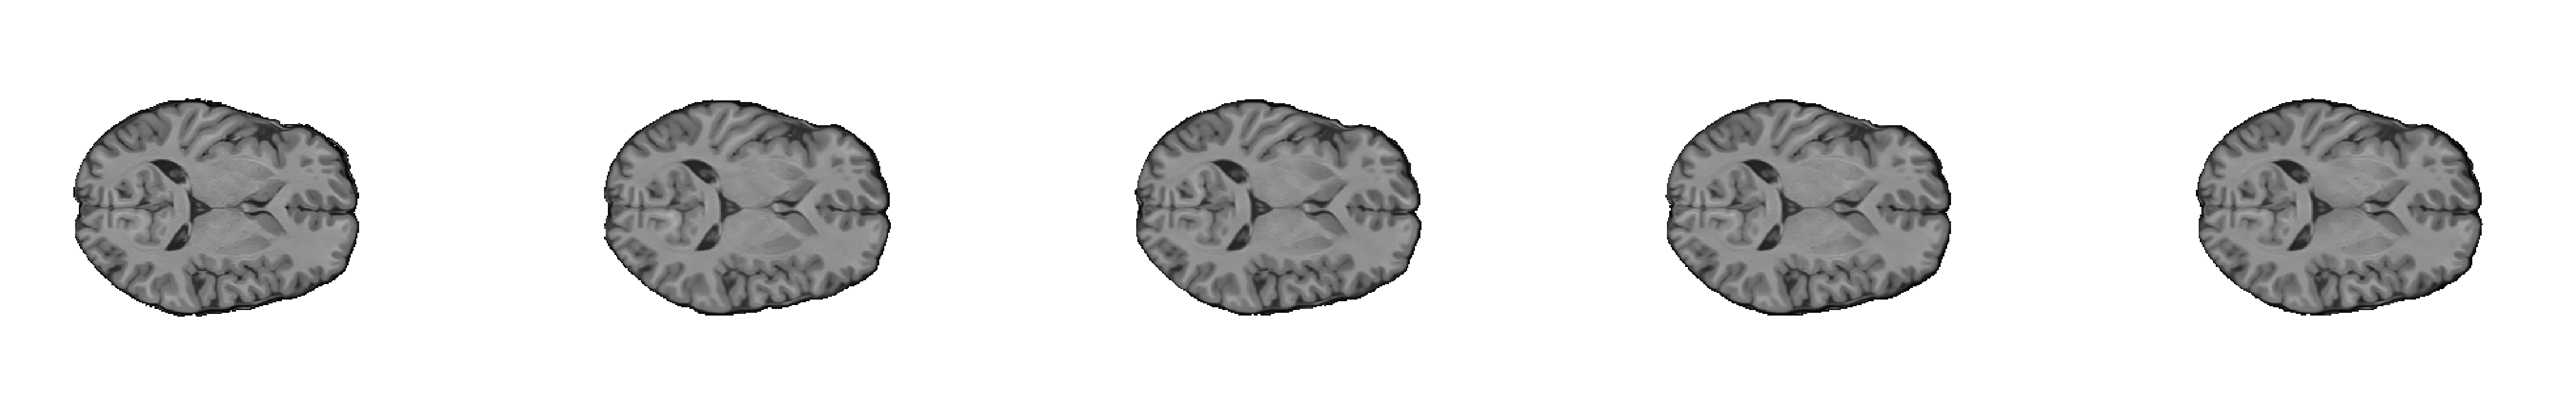

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=n_frames, figsize=(12*n_frames, 10))

for ax in axes:
    ax.axis("off")

for i, ax in enumerate(axes):
    ax.imshow(movie_data[..., i], interpolation="none", cmap=my_gray, vmin=0, vmax=max_int)

fig.savefig(op.join(figure_loc, "aligned_brains.png"), dpi=300, bbox_inches="tight", transparent=True)

# Plotting the first template

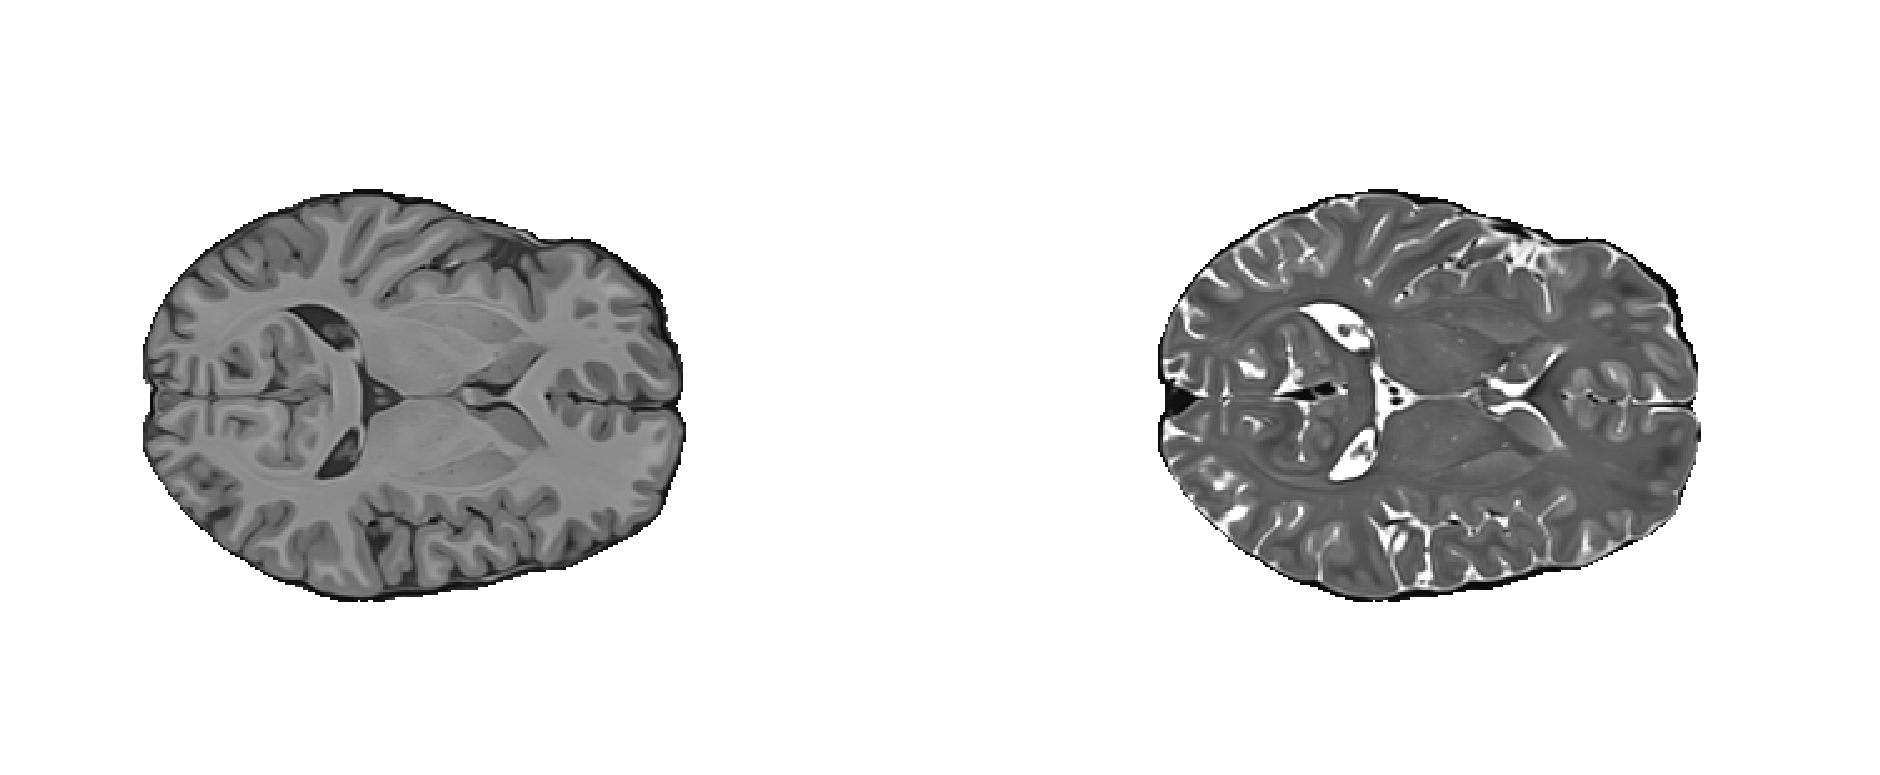

In [12]:
path_to_ants = op.join(path_to_images, "multivar-v00/derivatives/allInRef-noskull/intermediateTemplates")

path_to_ants_templates = [op.join(path_to_ants, f"Affine_iteration2_A_tpl_template{i}.nii.gz") for i in range(2)]

fig, axes = plt.subplots(ncols=2, figsize=(12*2, 10))

for ax in axes:
    ax.axis("off")

for i, ax in enumerate(axes):
    first_template_data = nib.load(path_to_ants_templates[i]).get_fdata()[:, :, z_coords]
    #np.abs(data)+10*mask_data[:, :, z_coords]
    ax.imshow((first_template_data+1)*mask_data[:, :, z_coords], interpolation="none", cmap=my_gray, vmin=0, vmax=22)

fig.savefig(op.join(figure_loc, "ANTs_Templates.png"), dpi=300, bbox_inches="tight", transparent=True)

['/Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates/Affine_iteration0_A_tpl_template0.nii.gz', '/Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates/Affine_iteration1_A_tpl_template0.nii.gz', '/Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates/Affine_iteration2_A_tpl_template0.nii.gz', '/Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates/Affine_iteration3_A_tpl_template0.nii.gz']


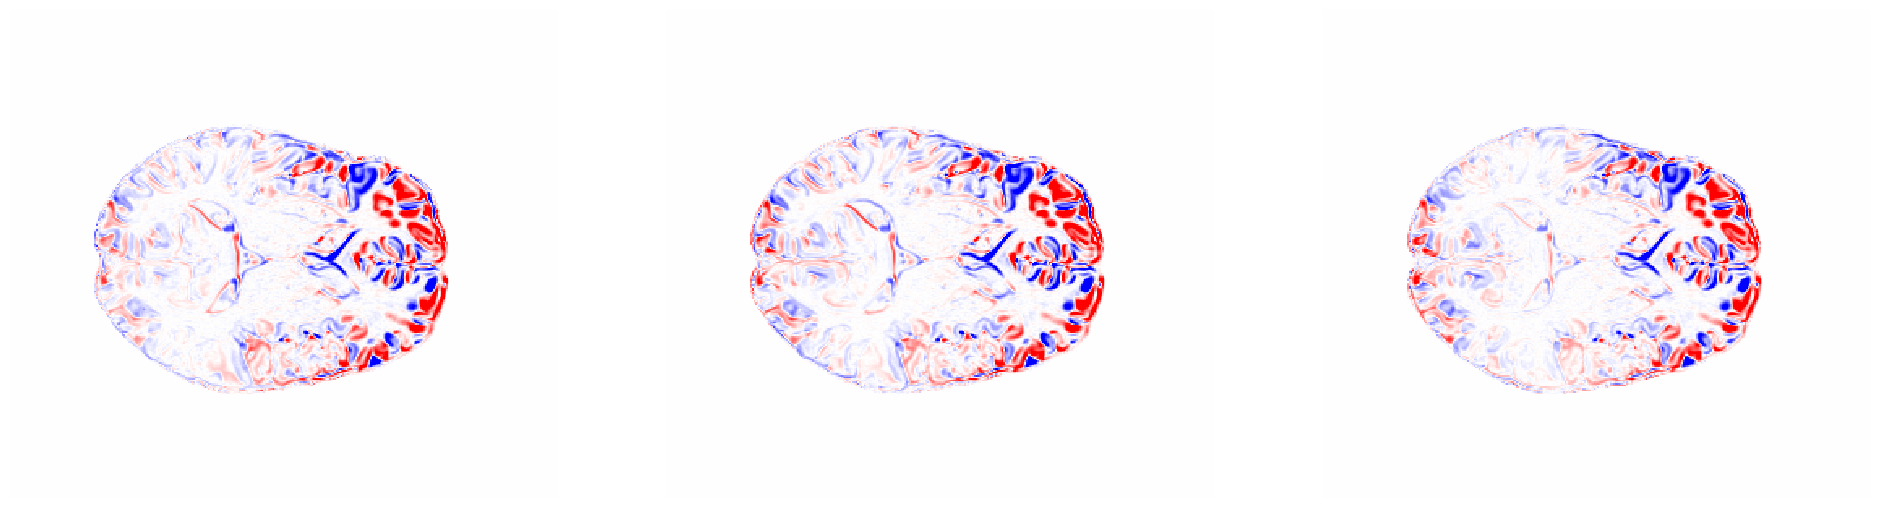

In [13]:
from skimage.filters import laplace

def laplacian_sharpen(img_array, alpha=1.0):
    laplacian_array = laplace(img_array)
    return img_array + alpha*laplacian_array

# /Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates/Affine_iteration0_A_tpl_template0.nii.gz
path_to_i4 = "/Users/acionca/data/hcph-template/multivar-v00/derivatives/allInRef-noskull-i4"
path_to_ants_templates = [op.join(path_to_i4, "intermediateTemplates", f"Affine_iteration{i}_A_tpl_template0.nii.gz") for i in range(4)]

print(path_to_ants_templates)

fig, axes = plt.subplots(ncols=len(path_to_ants_templates)-1, figsize=(12*2, 10))

for ax in axes:
    ax.axis("off")

for i, ax in enumerate(axes):
    #first_template_data = nib.load(path_to_ants_templates[i]).get_fdata()[:, :, z_coords]
    first_template_data = nib.load(path_to_ants_templates[i]).get_fdata()[:, :, z_coords]
    second_template_data = nib.load(path_to_ants_templates[i+1]).get_fdata()[:, :, z_coords]

    diff = second_template_data - first_template_data
    #diff = second_template_data/second_template_data.max() - first_template_data/first_template_data.max()
    
    max_diff = np.abs(diff).max()
    max_diff = .02
    #np.abs(data)+10*mask_data[:, :, z_coords]
    ax.imshow(diff, cmap="bwr", interpolation="none", vmin=-max_diff, vmax=max_diff)

fig.savefig(op.join(figure_loc, "diff_w_previous_iter.png"), dpi=300, bbox_inches="tight", transparent=True)

# Plotting the final templates

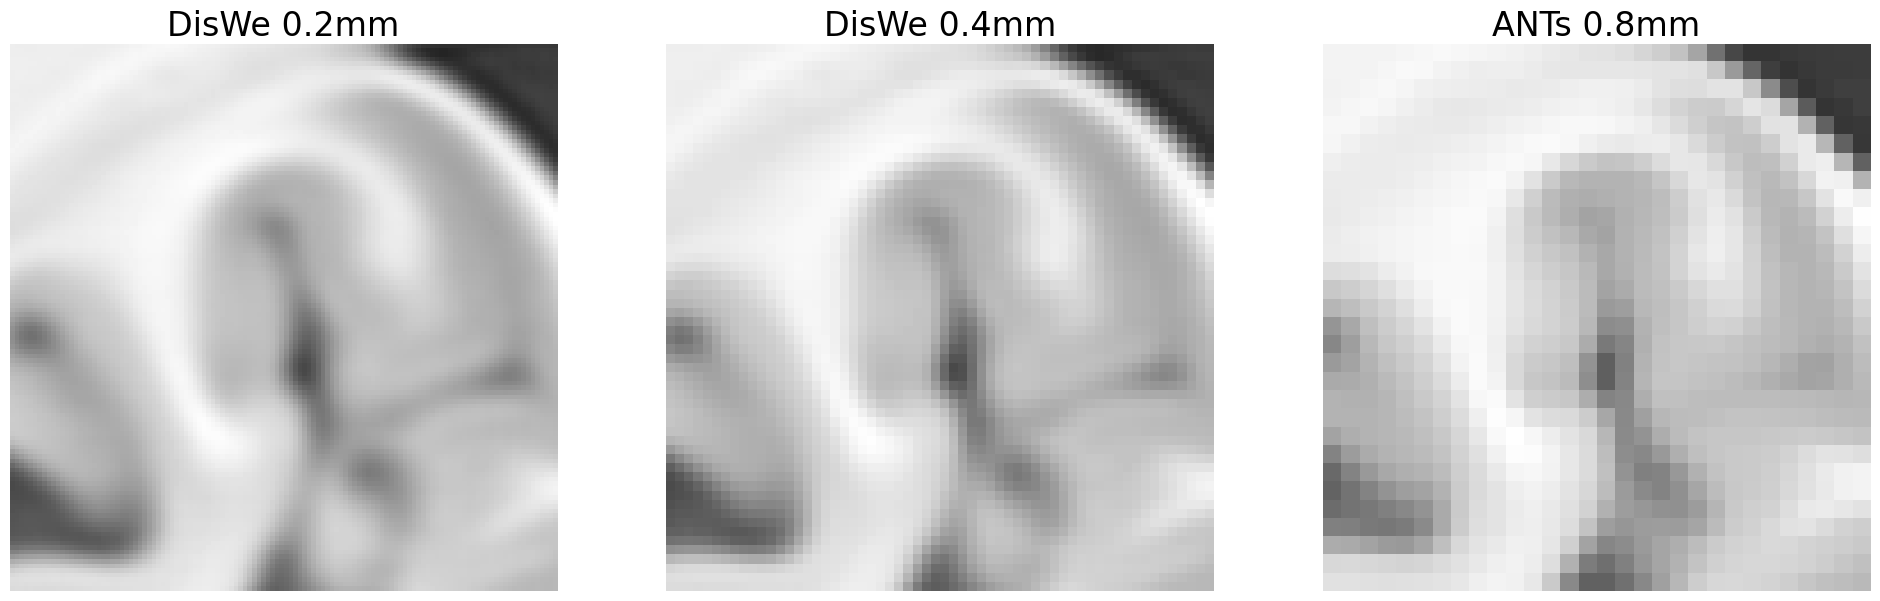

In [11]:
path_to_ants = op.join(path_to_images, "multivar-v00/derivatives/allInRef-noskull-i4/intermediateTemplates")
path_to_diswe = op.join(path_to_images, "multivar-v00/derivatives/diswe-interp-noskull-i4")

#path_to_diswe_02mm = "/Users/acionca/data/hcph-template/multivar-v00/derivatives/diswe-interp/distance_weighted_template_res-0.2_desc-N35T1w.nii.gz"
path_to_diswe_02mm = op.join(path_to_diswe, f"distance_weighted_template_res-0.2_desc-N35DisWei1T1w.nii.gz")
path_to_diswe_template = op.join(path_to_diswe, f"distance_weighted_template_res-0.4_desc-N35DisWei1T1w.nii.gz")
path_to_ants_template = op.join(path_to_ants, f"Affine_iteration3_A_tpl_template0.nii.gz")

templates_to_show = [path_to_diswe_02mm, path_to_diswe_template, path_to_ants_template]

resolution_factors = [4, 2, 1]

z_coords = 115
z_coords_template = [z_coords*res for res in resolution_factors]

#maxvals = [700, 14]
maxvals = [255]*len(templates_to_show)

zooms_x = [110, 150]
zooms_y = [80, 120]

fig, axes = plt.subplots(ncols=len(templates_to_show), figsize=(12*2, 10))

for ax in axes:
    ax.axis("off")

for i, (ax, z_coord_temp) in enumerate(zip(axes, z_coords_template)):
    first_template_data = nib.load(templates_to_show[i]).get_fdata()[:, :, z_coord_temp]

    zoomed_img = first_template_data[resolution_factors[i]*zooms_x[0]: resolution_factors[i]*zooms_x[1], resolution_factors[i]*zooms_y[0]: resolution_factors[i]*zooms_y[1]]
    normalized_img = 255*zoomed_img/zoomed_img.max()
    #first_template_data = nib.load(path_to_diswe_templates[i]).get_fdata()[300]
    #np.abs(data)+10*mask_data[:, :, z_coords]
    ax.imshow(normalized_img, cmap=my_gray, interpolation="none", vmin=0, vmax=maxvals[i])

axes[0].set_title("DisWe 0.2mm", fontsize=24)
axes[1].set_title("DisWe 0.4mm", fontsize=24)
axes[2].set_title("ANTs 0.8mm", fontsize=24)

fig.savefig(op.join(figure_loc, f"ANTs_vs_DisWe-zoom_x{zooms_x[0]}_{zooms_x[1]}y{zooms_y[0]}_{zooms_y[1]}.png"), dpi=300, bbox_inches="tight", transparent=True)

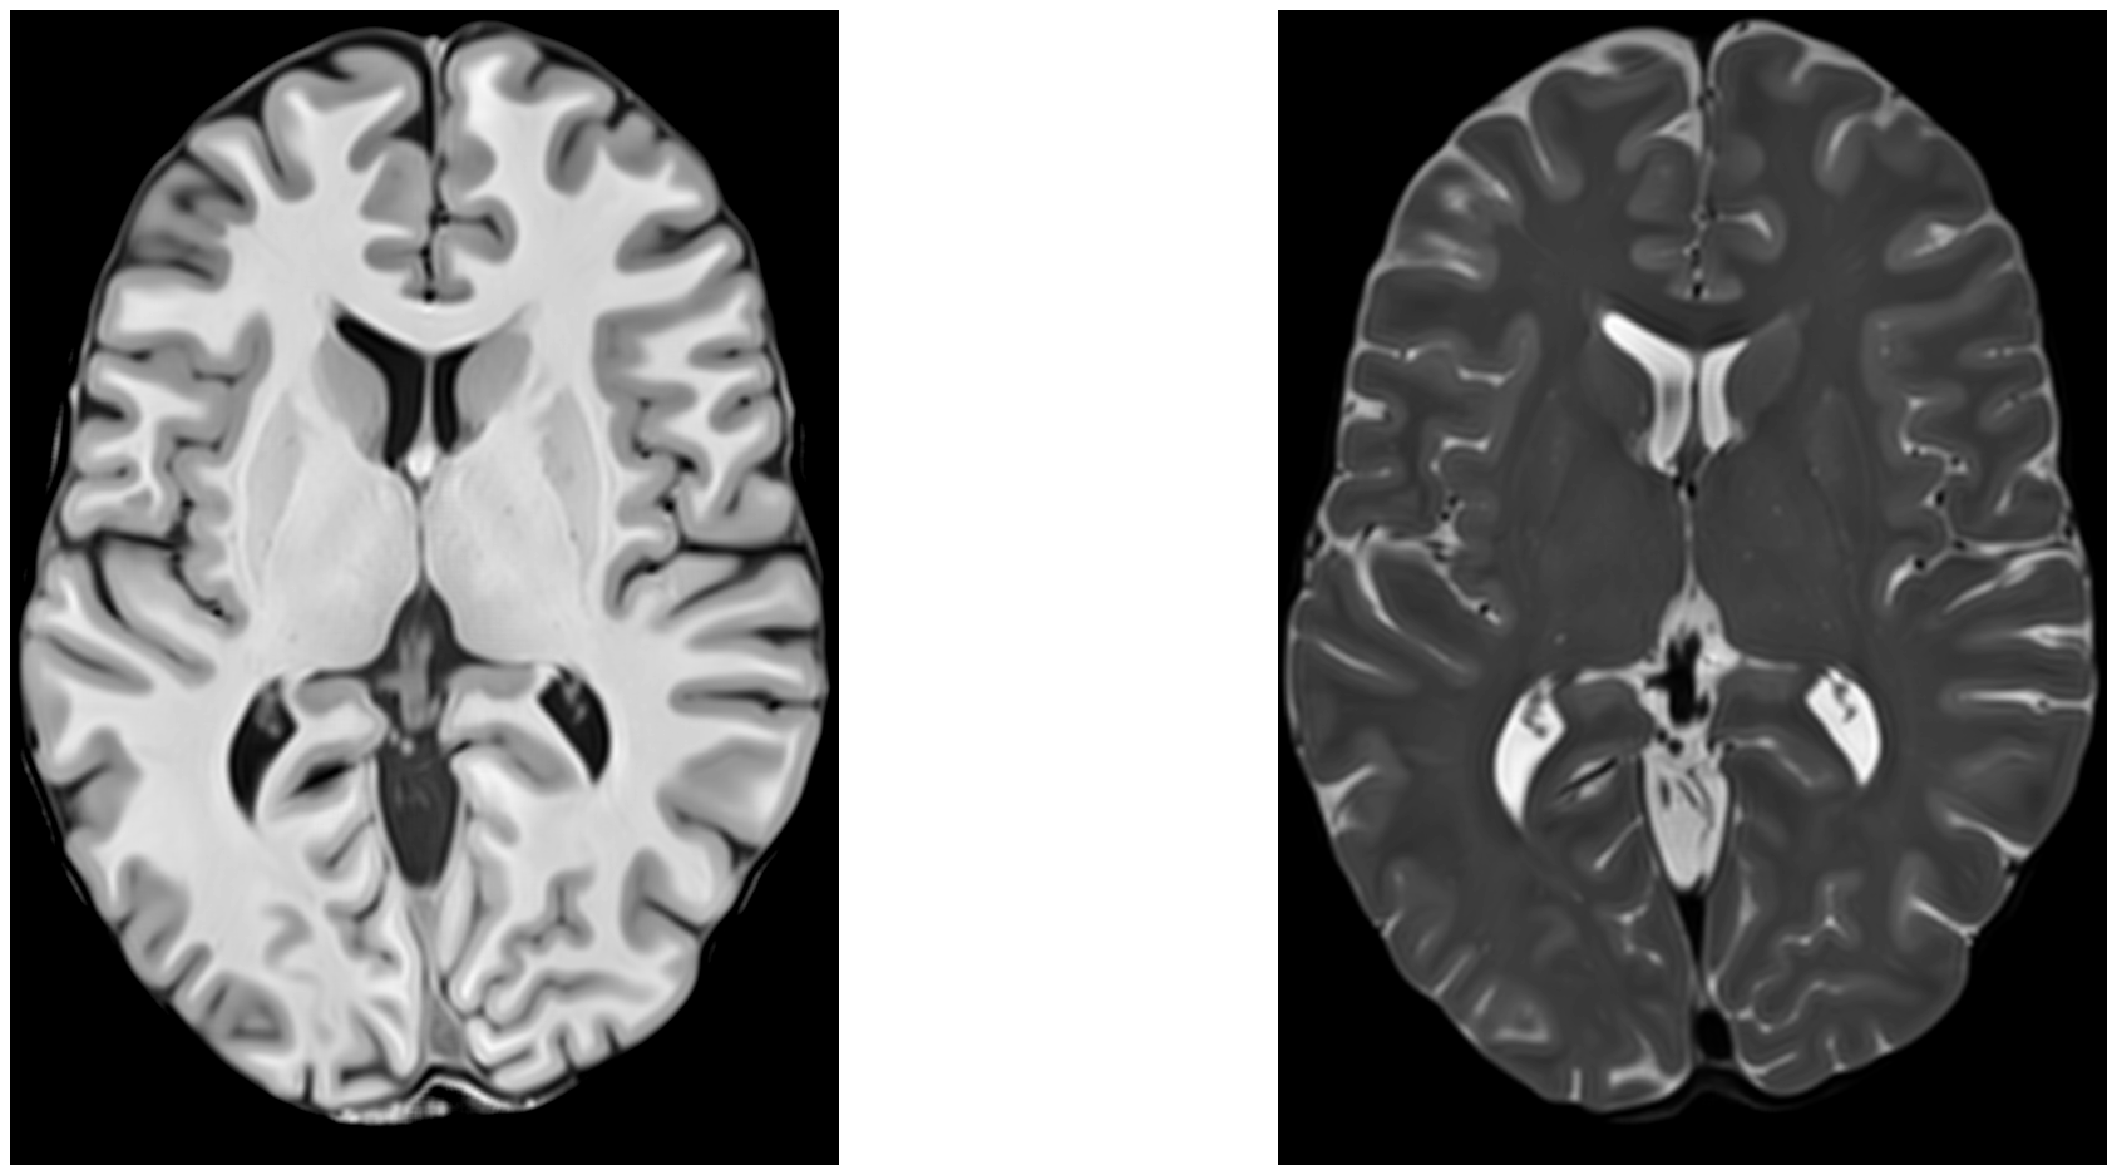

In [66]:
# distance_weighted_template_res-0.4_desc-N35DisWei1T1w.nii.gz
path_to_diswe = op.join(path_to_images, "multivar-v00/derivatives/diswe-interp-noskull-i4")

res = 0.2

# distance_weighted_template_res-0.4_desc-N35DisWei1to_MNI04mmRigidT1w.nii.gz
path_to_diswe_templates = [op.join(path_to_diswe, f"distance_weighted_template_res-{res:1.1f}_desc-N35DisWei1T{i+1}w.nii.gz") for i in range(2)]
path_to_diswe_templates = [op.join(path_to_diswe, f"distance_weighted_template_res-{res:1.1f}_desc-N35DisWei1to_MNI04mmRigidT{i+1}w.nii.gz") for i in range(2)]

in_mni = False
if "MNI" in path_to_diswe_templates[0]:
    in_mni = True

fig, axes = plt.subplots(ncols=2, figsize=(15*2, 15))

res_factor = int(0.8//res)


if in_mni:
    xzoom = 40
    yzoom = 30
    z_coords = 103
else:
    xzoom = 55
    yzoom = 50
    z_coords = 115

z_coords_template = [res_factor*z_coords]*2
zooms = [[res_factor*xzoom, -res_factor*xzoom],
         [res_factor*yzoom, -res_factor*yzoom]]

for ax in axes:
    ax.axis("off")

maxvals = [[40, 260], [0, 255]]

for i, (ax, z_coord_temp) in enumerate(zip(axes, z_coords_template)):
    first_template_data = nib.load(path_to_diswe_templates[i]).get_fdata()[:, :, z_coord_temp]

    #zoomed_img = first_template_data[110:-110, 100:-100]
    zoomed_img = first_template_data[zooms[0][0]:zooms[0][1], zooms[1][0]:zooms[1][1]]

    norm_img = 255*zoomed_img/zoomed_img.max()

    #first_template_data = nib.load(path_to_diswe_templates[i]).get_fdata()[300]
    #np.abs(data)+10*mask_data[:, :, z_coords]
    #ax.imshow(np.flip(zoomed_img.T, axis=0), cmap=my_gray, interpolation="none", vmin=0, vmax=600)
    #ax.imshow(np.flip(zoomed_img.T, axis=0), cmap="gray", interpolation="none", vmin=50, vmax=600)
    ax.imshow(np.flip(norm_img.T, axis=0), cmap="gray", interpolation="none", vmin=maxvals[i][0], vmax=maxvals[i][1])

res_str = f"{res*10:02.0f}"
fig.savefig(op.join(figure_loc, f"Interp_Templates_{res_str}mm-({maxvals})"+in_mni*"-MNI"+".png"), dpi=600, bbox_inches="tight", transparent=True)

# Rescale images to 0-255

In [110]:
from nilearn import image

maxval = 255
path_to_save = "/Users/acionca/data/hcph-template/multivar-v00/derivatives/diswe-rescale"

all_images = os.listdir(path_to_diswe)

all_images = [img_file for img_file in all_images if ".nii.gz" in img_file]
all_images = [img_file for img_file in all_images if f"r{maxval}" not in img_file]

for img_file in all_images:

    img_path = op.join(path_to_diswe, img_file)
    img = nib.load(img_path)

    rescaled = image.math_img("img / img.max()", img=img)

    rescaled_img = nib.Nifti1Image((maxval * rescaled.get_fdata()).astype(np.int16), affine=img.affine, dtype=np.int16)

    filename = op.basename(img_path).replace("N35DisWei1", "N35DisWei1r256")
    rescaled_img.to_filename(op.join(path_to_save, filename))

# Rename images with `_space-###_`

In [127]:
path_to_rescale = "/Users/acionca/data/hcph-template/multivar-v00/derivatives/diswe-rescale"

all_images = os.listdir(path_to_rescale)

all_images = [img_file for img_file in all_images if ".nii.gz" in img_file]

for img_file in all_images:
    space = "native"
    if "to_MNI04" in img_file:
        space = "MNI"
    elif "MovedToMNI" in img_file:
        continue

    filename = op.basename(img_file)

    pattern = "distance_weighted_template_res-{res}_space-{space}_desc-{desc}.nii.gz"

    all_fields = filename.split("_")

    all_fields[-1] = all_fields[-1].split(".")[0]
    modality = all_fields[-1][-3:]

    all_fields[-1] = all_fields[-1].replace(modality, "")

    name = "_".join(all_fields[:3])
    res = all_fields[3]
    desc = all_fields[4]

    if "to" in desc:
        desc = desc.replace("to", "")

    if len(all_fields) > 5:
        space_raw = all_fields[5]
        space_raw = space_raw.split(".")[0]
    else:
        space_raw = "native"

    file_rename = "_".join([name, res, "space-"+space_raw, desc+modality+".nii.gz"])

    os.rename(op.join(path_to_rescale, img_file), op.join(path_to_rescale, file_rename))

# Remove the `r256` from filenames

In [128]:
path_to_rescale = "/Users/acionca/data/hcph-template/multivar-v00/derivatives/diswe-rescale"

all_images = os.listdir(path_to_rescale)

all_images = [img_file for img_file in all_images if ".nii.gz" in img_file]

for img_file in all_images:

    filename = op.basename(img_file)

    file_rename = filename.replace("r256", "")

    os.rename(op.join(path_to_rescale, img_file), op.join(path_to_rescale, file_rename))